In [0]:
##imports 

#basic imports 
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

#models 
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

#cluster eval
from sklearn.metrics import silhouette_score 
from sklearn import metrics 

In [3]:
#read in data
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv') 
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [5]:
df.isnull().sum()

10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64

In [4]:
#we'll drop categorical variables as they aren't useful in K means clustering 
df.drop(['ctz','name','bib','state','country','city'],axis=1,inplace=True)
df.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,17.37,8,47.67,M,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,1,82.43,F,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,1,45.80,M,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,3,82.43,F,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,2,46.37,M,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72


In [7]:
df.iloc[3189]

10k               -
division        647
25k               -
gender            M
age              47
official     195.82
genderdiv      4815
35k          160.48
overall        5463
pace           7.48
30k               -
5k                -
half              -
20k               -
40k          184.62
Name: 3189, dtype: object

In [0]:
#convert splits to float value, replacing '-' in splits 
splits = ['10k','25k','35k','30k','5k','half','20k','40k']
for col in splits:
    df[col] = df[col].str.replace('-','')
    df[col] = pd.to_numeric(df[col])

In [0]:
#drop the null split values 
df = df.dropna()

In [0]:
#create binary outcome variable 
df.gender = np.where(df.gender == 'F',1,0)

In [9]:
df.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000
mean,51.629039,1922.747291,133.581175,0.447565,42.385067,241.952383,8002.921988,196.033373,15833.958924,9.236463,163.894883,25.678261,111.211481,105.321404,228.189990
std,8.710102,1704.843679,25.571480,0.497251,11.299795,50.842552,4733.255987,40.775036,9182.223743,1.939150,32.889354,4.215381,20.306387,19.159500,48.074493
min,16.620000,1.000000,45.800000,0.000000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,45.370000,607.000000,115.430000,0.000000,33.000000,205.300000,3940.000000,166.950000,7880.000000,7.830000,140.520000,22.620000,96.750000,91.670000,193.620000
50%,50.280000,1418.000000,128.850000,0.000000,42.000000,231.980000,7919.000000,187.850000,15829.000000,8.850000,157.500000,25.050000,107.680000,102.000000,218.470000
75%,57.000000,2601.000000,147.700000,1.000000,50.000000,272.200000,11893.000000,219.370000,23785.000000,10.380000,182.200000,28.400000,122.680000,116.150000,256.570000
max,112.380000,6979.000000,289.020000,1.000000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


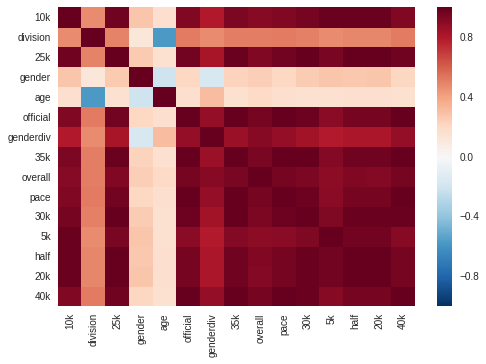

In [8]:
corr = df.corr()
sns.heatmap(corr)

In [0]:
X = df[['5k','10k','25k','30k','35k','40k','half','official','pace','overall','age','division','genderdiv']]
y = df['gender']


## K-Means 

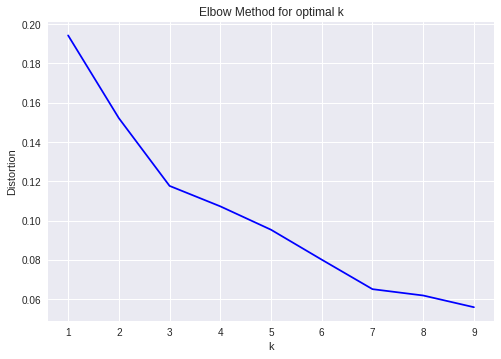

In [14]:
# Normalize the data.
X_norm = normalize(X)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_norm)
    kmeanModel.fit(X_norm)
    distortions.append(sum(np.min(cdist(X_norm, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_norm.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal k')
plt.show()

In [15]:
for n_cluster in range(2, 6):
    kmeans = KMeans(n_clusters=n_cluster).fit(X_norm)
    labels = kmeans.labels_
    sil_coeff = silhouette_score(X, labels, metric='euclidean')
    print("For {} clusters, our Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For 2 clusters, our Silhouette Coefficient is 0.3481365506349887
For 3 clusters, our Silhouette Coefficient is 0.010603189046789164
For 4 clusters, our Silhouette Coefficient is -0.06569106409373096
For 5 clusters, our Silhouette Coefficient is -0.022915380061776965


Looks like the best cluster here is 2 showcased both from the Elbow method and Silhouette score. 

In [16]:
    bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
    #Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)   
    # Extract cluster assignments for each data point.
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    # Count our clusters.
    n_clusters_ = len(np.unique(labels))
    # Get silhouette score 
    sil_coeff = silhouette_score(X,labels,metric='euclidean')
    print("For {} clusters, our Silhouette Coefficient is {}".format(n_clusters_, sil_coeff))

For 3 clusters, our Silhouette Coefficient is 0.4618019723855221


Seems that our Mean Shift model outperforms our KMeans with a Silhouette of .46 for 3 clusters. 

In [0]:
#session keeps crashing when run this cell? 
for n_cluster in range(2, 6):
  sc = SpectralClustering(n_clusters=n_cluster).fit(X)
  labels = sc.labels_
  sil_coeff = silhouette_score(X, labels, metric='euclidean')
  print("For {} clusters, our Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

In [1]:
#session crashes after execution of this cell as well 
af = AffinityPropagation().fit(X)
# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print("For {} clusters, our Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

NameError: ignored